# Class Assignments (Element 1)
Manuela Cleves

Task: We wanted to study if users with high mobile usage find a given visual search target faster than their counterparts and also to assess if there is any significant interaction with other IVs (eg: Gender, Age etc.,)?

Note: each section includes all neccesary comments, justification and sources used

# 0. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import statsmodels.api as sm

import statsmodels.api as sm 
from statsmodels.formula.api import ols 
from scipy import stats
from scipy.stats import bartlett
from scipy.stats import kruskal
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. Check Data quality:
    
    a. Create a Data Pre-processing pipeline with only the necessary tasks such a way that you confirm the current dataset is all set for next steps.
    b. Record the data shape at this stage
    Note: This to be supported with necessary comments and justifications throughout the process. 
    

**Process:** 
    
In order to clean and prepare our data for analysis, we will complete the following steps:
1) Read the data and convert it to a data frame
2) Ensure our code is all lowercase and free of spaces (in the case of string values) and numeric (for all other values)
3) We will convert the "Device" variable to a categoric value, this is neccesary for a task described further on
4) Identify missing values and replace them with "np.nan"
5) Analyze the potential causes of these missing values and patterns between them in order to classify them as Missing Completely At Random (MCAR), Missing At Random (MAR) or Missing Not At Random (MNAR). 
6) Depending on the classification of each missing variable, we will pick appropriate methods for value imputation, or delete the values.

Since we will start with an exploratory analysis, we will not check the correlation between variables from the start. Our exploratory findings are not neccesarily statistically significant.

**Sources used for this section:**

Analytics Vidhya. (2021, October 14). Handling Missing Values: What Is a Missing Value? https://www.analyticsvidhya.com/blog/2021/10/handling-missing-value/#What_Is_a_Missing_Value?

DataCamp. (n.d.). Techniques to Handle Missing Data Values. https://www.datacamp.com/tutorial/techniques-to-handle-missing-data-values

ChatGPT 3.5.


In [2]:
# Reading the data and converting it to a data frame
df= pd.read_csv("../FinalClassAssignment/MASTER_PhonesmartdataAll_CCI_AdvStats.csv")

# Converting non-string values into numeric values
df['VS_RT_correct_Single'] = pd.to_numeric(df['VS_RT_correct_Single'], errors='coerce')
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
df['VS_RT_correct_Conjunction'] = pd.to_numeric(df['VS_RT_correct_Conjunction'], errors='coerce')
df['STAI'] = pd.to_numeric(df['STAI'], errors='coerce')
df['BRIEF_Total'] = pd.to_numeric(df['BRIEF_Total'], errors='coerce')
df['DailyAvgMins'] = pd.to_numeric(df['DailyAvgMins'], errors='coerce')
df['DailyAvePickups'] = pd.to_numeric(df['DailyAvePickups'], errors='coerce')
df['GenderNum'] = pd.to_numeric(df['GenderNum'], errors='coerce')

# Converting string values into lowercase, space free strings
df['Device'] = df['Device'].str.strip().str.lower().replace('iphone', 'iphone', regex=True)
df['Device'] = df['Device'].str.strip()

# Converting the variable "Device" into a categoric variable that starts at "1"
df['Device'] = df['Device'].astype('category')
df['Device'] = df['Device'].cat.codes + 1

In [3]:
#Now we check for missing values and replace them with "np.nan"

total_missing_values = df.isnull().sum().sum()
print("Total number of missing values in the entire DataFrame:", total_missing_values)

missing_values_per_column = df.isnull().sum()
print("Number of missing values for each column:")
print(missing_values_per_column)

df.replace(['NA', 'N/A','',' '], np.nan, inplace=True)

#Next, we make sure no column has leading or trailing whitespaces
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

Total number of missing values in the entire DataFrame: 651
Number of missing values for each column:
Year                           0
Age                           25
GenderNum                     10
AutismQuotient                 0
STAI                           9
BRIEF_Total                    7
Device                         0
DailyAvgMins                 183
DailyAvePickups              417
VS_RT_correct_Conjunction      0
VS_RT_correct_Single           0
dtype: int64


In [4]:
df.head()

,Year,Age,GenderNum,AutismQuotient,STAI,BRIEF_Total,Device,DailyAvgMins,DailyAvePickups,VS_RT_correct_Conjunction,VS_RT_correct_Single
0,2022,NaN,2.0,4,49.0,70.0,1,NaN,NaN,1178.700000,1216.387500
1,2021,37.0,2.0,8,44.0,33.0,1,NaN,NaN,946.470000,785.597500
2,2022,NaN,1.0,NaN,NaN,NaN,1,NaN,NaN,1182.741667,950.900000
3,2022,NaN,1.0,NaN,NaN,NaN,1,NaN,NaN,1778.950000,984.333333
4,2022,NaN,2.0,NaN,NaN,NaN,1,NaN,NaN,521.500000,503.000000


In [5]:
#Checking the gender balance of the data
df["GenderNum"].value_counts()

#We can conclude that we have a gender imbalance and are mainly dealing with "gender 2"

GenderNum
2.0    414
1.0    118
3.0      6
Name: count, dtype: int64

In [6]:
#Checking the age balance of the data
df["Age"].value_counts()

#We can conclude that we are mainly dealing with young people who perhaps use their phones more than older people.

Age
27.0     35
30.0     33
26.0     31
28.0     31
31.0     27
29.0     26
21.0     25
25.0     23
20.0     23
24.0     22
33.0     21
23.0     21
32.0     20
34.0     20
19.0     19
35.0     17
22.0     16
36.0     12
37.0     12
38.0     11
44.0      9
39.0      8
42.0      8
41.0      7
40.0      7
45.0      6
48.0      5
47.0      4
51.0      4
46.0      3
49.0      3
43.0      3
18.0      2
16.0      1
62.0      1
101.0     1
60.0      1
52.0      1
53.0      1
50.0      1
61.0      1
59.0      1
Name: count, dtype: int64

In [7]:
#We realize that our data is not balanced in terms of Gender or age. 
#So, we check if there seems to be a difference between the means of the DailyAvePickups and DailyAvgMins of the different genders and ages

In [8]:
#Gender
#We assign a "4th gender category" to all those who left gender blank
df['GenderNum'] = df['GenderNum'].fillna(4)

#We filter out data frame by gender in order to calculate the means of DailyAvgMins and DailyAvePickups for each gender
filtered_df1 = df[df["GenderNum"] == 1]
filtered_df2 = df[df["GenderNum"] == 2]
filtered_df3 = df[df["GenderNum"] == 3]
filtered_df4 = df[df["GenderNum"] == 4]

print("DailyAvgMins Means:"+str(filtered_df1["DailyAvgMins"].mean()) + ", " +
      str(filtered_df2["DailyAvgMins"].mean()) + ", " +
      str(filtered_df3["DailyAvgMins"].mean()) + ", " +
      str(filtered_df4["DailyAvgMins"].mean()))

print("DailyAvePickups Means:"+str(filtered_df1["DailyAvePickups"].mean()) + ", " +
      str(filtered_df2["DailyAvePickups"].mean()) + ", " +
      str(filtered_df3["DailyAvePickups"].mean()) + ", " +
      str(filtered_df4["DailyAvePickups"].mean()))

DailyAvgMins Means:259.2368421052632, 273.38214285714287, 327.0, 408.8
DailyAvePickups Means:100.36363636363636, 105.79047619047618, 131.0, 73.0


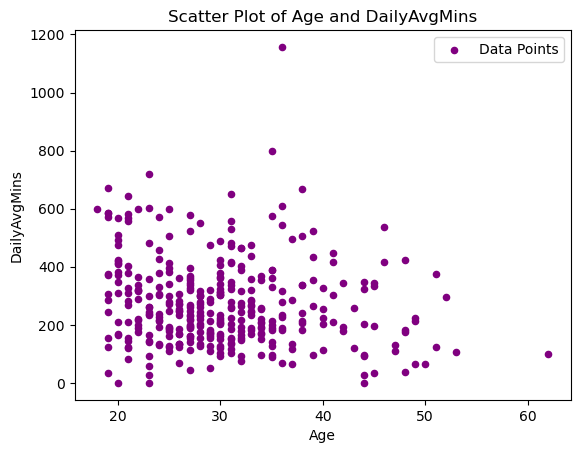

In [9]:
#Age - We can easily identify evident patterns by using a scatter plot

# Create a scatter plot with appropriate labels for DailyAvgMins
plt.scatter(df['Age'], df['DailyAvgMins'], marker='o', color='purple', s=20, label='Data Points')

plt.xlabel('Age')
plt.ylabel('DailyAvgMins')
plt.title('Scatter Plot of Age and DailyAvgMins')

plt.legend()

# Show the plot
plt.show()

#We can conclude that apart from a few outlyers there doesn't seem to be an evident pattern in the distribution

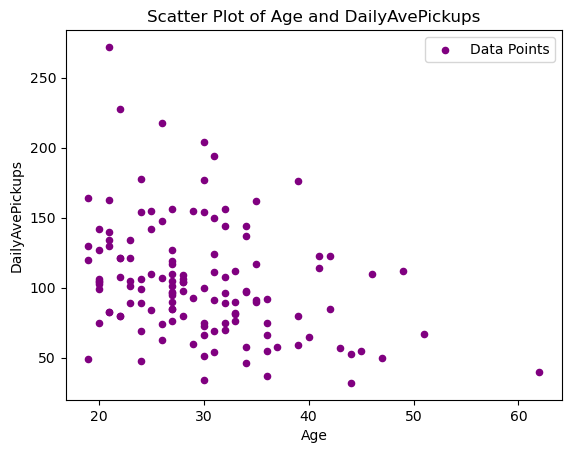

In [10]:
#Age - We can easily identify evident patterns by using a scatter plot

# Create a scatter plot with appropriate labels for DailyAvgMins
plt.scatter(df['Age'], df['DailyAvePickups'], marker='o', color='purple', s=20, label='Data Points')

plt.xlabel('Age')
plt.ylabel('DailyAvePickups')
plt.title('Scatter Plot of Age and DailyAvePickups')

plt.legend()

# Show the plot
plt.show()

#We can conclude that apart from a few outlyers there doesn't seem to be an evident pattern in the distribution

In [11]:
#Now, we want to take a look at STAI and BRIEF_Total values. Specifically, we want to identify evident patterns between these two and any other variables.
#To accomplish this, we will compare the means of other variables for participants who have missing values in STAI and BRIEF_Total and those who don't.

In [12]:
# Create a filter that will allow us to calculate the mean of our usage variables for participants with and without STAI and BRIEF_Total values

#STAI

filtereddf_NoSTAI = df[df['STAI'].isna()]
filtereddf_STAI = df[df['STAI'].notna()]

mins_mean_missingSTAI = filtereddf_NoSTAI['DailyAvgMins'].mean()
mins_mean_withSTAI = filtereddf_STAI['DailyAvgMins'].mean()
picks_mean_missingSTAI = filtereddf_NoSTAI['DailyAvePickups'].mean()
picks_mean_withSTAI = filtereddf_STAI['DailyAvePickups'].mean()

# Display the means
print("DailyAvgMins - Means without STAI:")
print(mins_mean_withSTAI, mins_mean_missingSTAI)

print("DailyAvePickups - Mean with STAI:")
print(picks_mean_withSTAI, picks_mean_missingSTAI)

#For the DailyAvgMins, We can conclude that the means are really similar and so there does not seem to be a hidden pattern that may drastically disrupt our analysis if we delete these values
#For the DailyAvePickups, our mean does seem to be sufficiently different to be pointing to a pattern.

DailyAvgMins - Means without STAI:
272.6942148760331 306.5
DailyAvePickups - Mean with STAI:
104.76335877862596 nan


In [13]:
#With some quick, complementary analysis we can determine if the difference is enough for us to explore more complex computation methods or if we can just delete the rows.

min=df['DailyAvePickups'].min()
max=df['DailyAvePickups'].max()

print ("Range of values:")
print (min,max)

percentage_difference = abs(picks_mean_withSTAI - picks_mean_missingSTAI) / ((picks_mean_withSTAI + picks_mean_missingSTAI) / 2) * 100

print ("Percentage change of mean:")
print (percentage_difference)

#While the means may seem quite different at first glance, we do realize that a 12% difference while having just 7 missing values is not a lot. We decide to delete the data.
#Had there been more missing STAI values, we would have to try different imputation methods.

Range of values:
32.0 272.0
Percentage change of mean:
nan


In [14]:
#BRIEF_Total

filtereddf_NoBRIEF = df[df['BRIEF_Total'].isna()]
filtereddf_BRIEF = df[df['BRIEF_Total'].notna()]

mins_mean_missingBRIEF= filtereddf_NoBRIEF['DailyAvgMins'].mean()
mins_mean_withBRIEF = filtereddf_BRIEF['DailyAvgMins'].mean()
picks_mean_missingBRIEF = filtereddf_NoBRIEF['DailyAvePickups'].mean()
picks_mean_withBRIEF = filtereddf_BRIEF['DailyAvePickups'].mean()

# Display the means
print("DailyAvgMins - Means without BRIEF:")
print(mins_mean_withBRIEF, mins_mean_missingBRIEF)

print("DailyAvePickups - Mean with BRIEF:")
print(picks_mean_withBRIEF, picks_mean_missingBRIEF)

#For the DailyAvgMins, We can conclude that the means are really similar and so there does not seem to be a hidden pattern that may drastically disrupt our analysis if we delete these values
#For the DailyAvePickups, our mean does seem to be sufficiently different to be pointing to a pattern.

DailyAvgMins - Means without BRIEF:
272.6730769230769 348.0
DailyAvePickups - Mean with BRIEF:
104.76335877862596 nan


In [15]:
#Once again, With some quick, complementary analysis we can determine if the difference is enough for us to explore more complex computation methods or if we can just delete the rows.

percentage_difference = abs(picks_mean_withBRIEF - picks_mean_missingBRIEF) / ((picks_mean_withBRIEF + picks_mean_missingBRIEF) / 2) * 100

print ("Percentage change of mean:")
print (percentage_difference)

#While the means may seem quite different at first glance, we do realize that a 13% difference while having just 9 missing values is not a lot. We decide to delete the data.
#Had there been more missing STAI values, we would have to try different imputation methods.

Percentage change of mean:
nan


**Justification for Dealing with missing values**

**From the data, we can make the following observations:**
- We see that more than half of the missing values are found in the **"DailyAvePickups"**. We can also see that that 98% of the 183 participants with missing values for **"DailyAvgMins"**, are also missing an value for "DailyAvePickups". This represents a significant proportion of our data and so these missing values need to be dealt with appropriately in order to minimize the risk of bias or of overlooking important imformation.

- We also know that the participants did not directly report their daily average minutes of usage and therefore we know that the reason for these values being missing is not participants' reluctance to give out information. Since there are no visible patterns we will assume that we are dealing with **Completely at Random Values**.

- In order to minimize any risk of bias, we will not delete these rows of missing values. We will test out different imputation methods for both "DailyAvgMins" and "DailyAvePickups"in order to model the missing values in the most appropriate way.

- Other variables with missing values are Gender, Autism Quotient and Age. Observations for these variables are described below:
    - **Gender:** We assume that the people that did not report their gender did so intentially, and so will not assign them to another category. We will keep this as a 4th category within this categorical value. We will use these "missingness" as a feature. This is mainly because we find that there does seem to be a difference between the average daily minutes and pickups of people that did not report a gender (it seems to be less) and so therefore gender might be a crucial value in understanding daily pickups and daily minutes of use. Since the data is not balanced betweed genders and we do not want to bias the data or hide useful information by assuming peoples gender.
    - **Autism Quotient (6 missing values)** Not relevant for our analysis.
    - **Device (154 missing values):** Not relevant for our analysis.
    - **STAI (9 missing values):** We don't notice any evident patterns so we assume we are dealing with **Missing Completely at Random Values**. Since these missing values account for less than 5% of the values we will delete these rows.
    - **BRIEF_Total (7 missing values):** We don't notice any evident patterns so we assume we are dealing with **Missing Completely at Random Values**. Since these missing values account for less than 5% of the values we will delete these rows.
    - **Age 25 (7 missing values):** There does not seem to be any sort of pattern, we assume that we are dealing with **Completely at Random Missing values** and because they are so few, we will delete these rows.

**Here is how we will handle the missing values:**
- **DailyAvgMins (183 missing values):** 
    - Since it's a continous variable, we try to replace the missing values with the mean. In order to do this, we must first check if there are outlyers in DailyAvgMins. We will also test out the imputation method of KNNImputer.
    - Because we've already identified thatthere might be a hidden pattern relating to gender within the dataset, we will check if there seems to be a difference between the means of the DailyAvgMins of the different genders. If there appears to be a difference, we will replace the missing values of eachone with the mean of each oner. If there does not appear to be a difference, we will replace all missing values of this variable with the global mean.
- **DailyAvePickups (417 missing values):** 
    - We will follow the same process detailed above for DailyAvgMin.
- **Gender (10 missing values):**
    - We assume that the people that did not report their gender did so intentially, and so will not assign them to another category. We arrived at this conclusion because there does seem to be a difference in the mean of DailyAvgMins and DailyPickups of participants who did not report their gender. We will keep this as a 4th category within this categorical value, ussing **Missingness as a feature**.

 

**Dealing with missing values**

**Age, BRIEF_Total and STAI**

In [16]:
# Drop rows with NaN values in columns, Age, BRIEF_Total and STAI

columns_to_delete0=['Age','BRIEF_Total','STAI']
df = df.dropna(subset=columns_to_delete0)


**DailyAvgMins and DailyAvePickups**

We find that there does seem to be a difference between genders and so therefore gender might be a crucial value in understanding daily pickups and daily minutes of use. Since the data is not balanced betweed genders and we do not want to bias the data or hide useful information by filling all empty values of these variables with the global mean, we will explore replacing the missing values of each gender with the mean of that specific gender.

We will try 3 different methods for value imputation to compare wether the results differ and define the most appropriate approach. The 3 methods are: 1) Multivariate Regression Imputation, 2) Replacing with the mean and 3) Rebalancing the genders within the datasets.

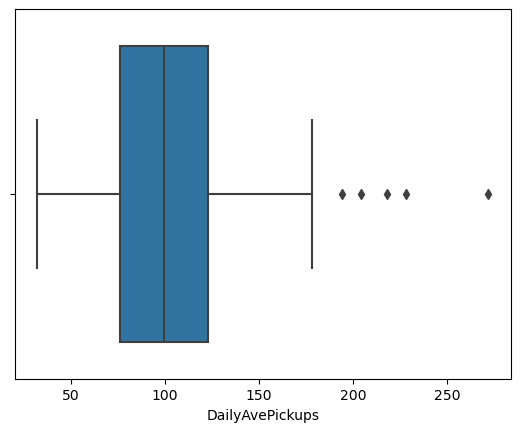

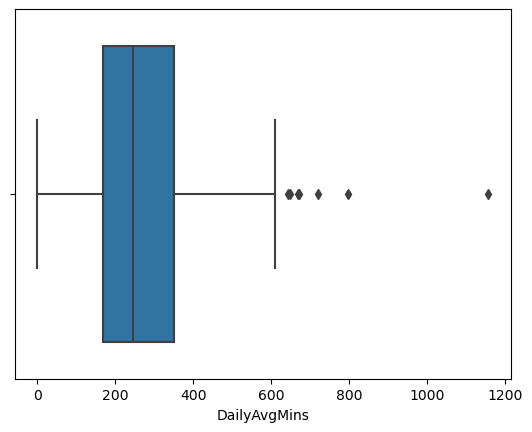

In [17]:
#Replacing with the mean

#We first need to check for outliers in order to determine if replacing with the mean is an appropriate imputation strategy

sns.boxplot(x=df['DailyAvePickups'])
plt.show()

sns.boxplot(x=df['DailyAvgMins'])
plt.show()

Both DailyAvgMins and DailyAvePickups seem to have outliers and so replacing missing values with the mean would not be appropriate.
We can move on to the other two methods we are exploring.

In [18]:
#Multivariate Approach using KNNImputer to replace missing values based on the k-nearest neighbors

# Column to impute using KNNImputer
columns_to_impute_with_knn = ['DailyAvePickups', 'DailyAvgMins']
columns_to_skip_knn = [col for col in df.columns if col not in columns_to_impute_with_knn]

# Create KNNImputer instance for the specified column
knn_imputer = KNNImputer(n_neighbors=2)

# Impute the specified column using KNNImputer
imputed_values = knn_imputer.fit_transform(df[columns_to_skip_knn + columns_to_impute_with_knn])

# Assign the imputed values back to the DataFrame
df[columns_to_impute_with_knn] = imputed_values[:, -len(columns_to_impute_with_knn):]



# Print the DataFrame after imputation
print(df)

     Year   Age  GenderNum AutismQuotient  STAI  BRIEF_Total  Device  \
1    2021  37.0        2.0              8  44.0         33.0       1   
5    2020  24.0        2.0              6  47.0          0.0       1   
6    2022  28.0        2.0              6  49.0         70.0       1   
7    2021  31.0        2.0              1  43.0         44.0       3   
8    2021  33.0        2.0              2  51.0         24.0       3   
..    ...   ...        ...            ...   ...          ...     ...   
543  2020  38.0        1.0              3  56.0         39.0       3   
544  2020  27.0        2.0              5  64.0         77.0       3   
545  2020  36.0        2.0              2  46.0         43.0       3   
546  2020  31.0        2.0              4  67.0         69.0       3   
547  2020  35.0        2.0              1  42.0         24.0       3   

     DailyAvgMins  DailyAvePickups  VS_RT_correct_Conjunction  \
1           180.5            101.5                 946.470000   
5    

**Gender**

In [19]:
#We've already replaced missing values for this variable when assigning a "4th gender category" to all those who left gender blank. 
#In this case, we are using "Missingness as a feature"
#This was the line of code used: df['GenderNum'] = df['GenderNum'].fillna(4)

**Recording the data shape**

In [20]:
df.shape

#The original shape was (548,11) now it is (519,11), we have only deleted 5% of the participants and so can feel confident that we are not incurring in a high bias risk.

(519, 11)

# 2. Data Relationship/Distribution:

a. Provide a Frequency table and an appropriate plot to visualize Pickup counts
split by gender.

b. Provide a Frequency table and at least 2 different types of plots to visualize the
distribution of Daily average minutes.

c. Provide at least 2 appropriate plots (for each) to check the relationship between
the

    i. Participant’s age and their Response time on singleton visual search
    
    ii. Participant’s gender and their Response time on conjunction visual
    search

**Sources used for this section:**

GeeksforGeeks. (n.d.). How to Create a Triangle Correlation Heatmap in Seaborn (Python). https://www.geeksforgeeks.org/how-to-create-a-triangle-correlation-heatmap-in-seaborn-python/

GeeksforGeeks. (n.d.). Create a Correlation Matrix using Python. https://www.geeksforgeeks.org/create-a-correlation-matrix-using-python/

Social Science Computing Cooperative (SSCC).(n.d.). ggplot2: Guide to Create Beautiful Graphics in R. https://sscc.wisc.edu/sscc/pubs/DWE/book/3-3-sect-ggplot-categorical.html

Stack Overflow. (n.d.). How to change the x-axis range in Seaborn? https://stackoverflow.com/questions/54822884/how-to-change-the-x-axis-range-in-seaborn

DataCamp. (n.d.). Seaborn Tutorial: Learn to Visualize Your Data. https://www.datacamp.com/tutorial/seaborn-python-tutorial

Pianalytix. (n.d.). Data Visualization Using Seaborn and Types of Plots in Seaborn. https://pianalytix.com/data-visualization-using-seaborn-and-types-of-plots-in-seaborn/

gshanbhag525. (n.d.). Programming Knowledge: Data Visualization in Data Science. https://github.com/gshanbhag525/Programming-Knowledge-/blob/master/Data%20Visualization%20in%20Data%20Science.ipynb

Medium - analyttica. (n.d.). Density Plots. https://medium.com/@analyttica/density-plots-8b2600b87db1#:~:text=Density%20plots%20are%20used%20to%20observe%20the%20distribution%20of%20a,are%20a%20variation%20of%20Histograms.

ChatGPT 3.5.

**a. Create a Frequency table and an appropriate plot to visualize Pickup counts split by gender.**

In [21]:
#Create the frequency tablem, we have already calculated the means for each gender in the above section so will not include this column
frequencyTable=df.groupby('GenderNum')['DailyAvePickups'].value_counts().unstack(fill_value=0)
frequencyTable

DailyAvePickups,32.0,34.0,37.0,40.0,43.5,44.5,46.0,48.0,49.0,50.0,...,186.0,189.0,194.0,196.0,204.0,208.0,216.0,218.0,228.0,272.0
GenderNum,,,,,,,,,,,,,,,,,,,,,
1.0,0,0,0,0,0,0,0,0,0,1,...,0,1,0,1,0,2,0,0,0,1
2.0,1,1,1,1,1,2,1,1,1,0,...,1,1,1,1,1,1,1,2,1,0
3.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


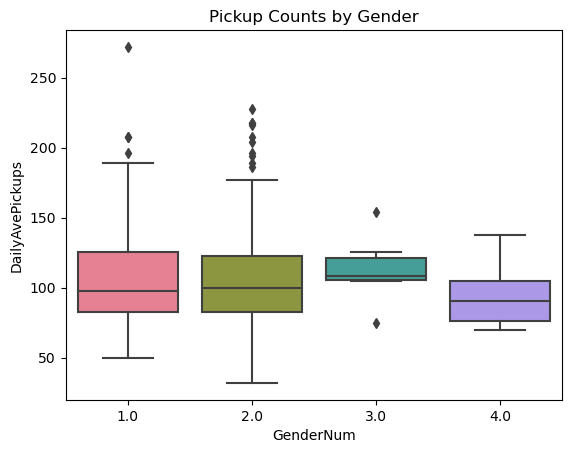

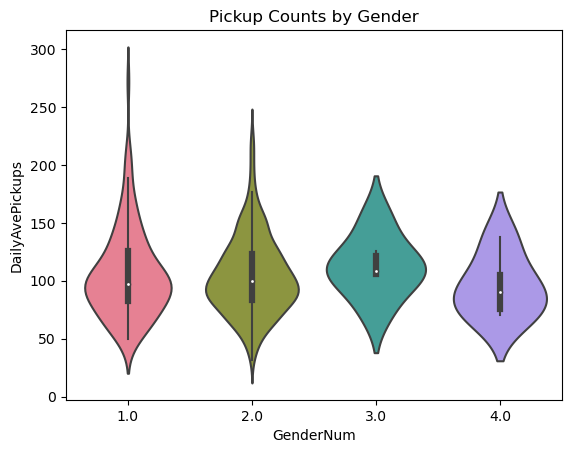

In [22]:
#With box and violin plots we can easily compare means and variance for the DailyAvePickups amongst different genders.
sns.boxplot(x='GenderNum', y='DailyAvePickups', data=df, palette='husl')
plt.title('Pickup Counts by Gender')
plt.show()

sns.violinplot(x='GenderNum', y='DailyAvePickups', data=df, palette='husl')
plt.title('Pickup Counts by Gender')
plt.show()

#We can conclude that the 3rd gender has a reduced variance in their DailyAvePickups while the mean of the people that left their gender blank (4th) seem to have a reduced mean.
#We can also conclude that genders 1 and 3 have their mean closer to their lower limit, while gender 2 and 4 have their mean closer to the median.

Text(0, 0.5, 'Density')

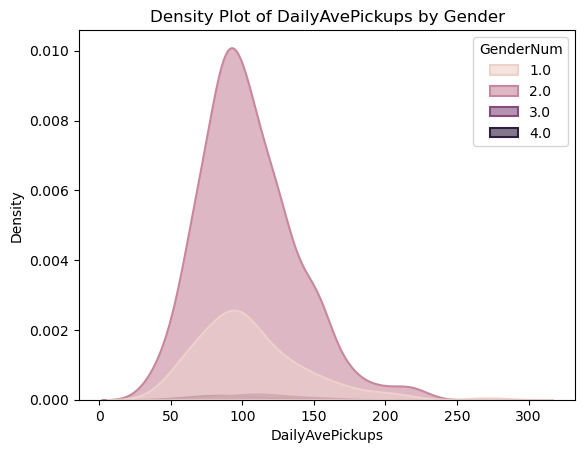

In [23]:
# With a density plot we can observe the distribution DailyAvePickups by Gender in a way that is easy to compare. Density plots are a variation of Histograms.
# We create the plot and adjust the "alpha" and "linewidth" parameters to make the plot more visually appealing and add the neccesary labels.

sns.kdeplot(data=df, x="DailyAvePickups", hue="GenderNum",fill=True, alpha=0.6, linewidth=1.5)

plt.title("Density Plot of DailyAvePickups by Gender")

plt.xlabel("DailyAvePickups")

plt.ylabel("Density")

#We can conclude what we already saw in the previous graphs, genders 3 and 4 seem to have a lesser variance.

**b. Provide a Frequency table and at least 2 different types of plots to visualize the distribution of Daily average minutes.**

In [24]:
frequency_table = df['DailyAvgMins'].value_counts().reset_index().rename(columns={'index': 'Minutes', 'DailyAvgMins': 'Frequency'})
print(frequency_table)

     Frequency  count
0        194.0      6
1        190.0      5
2        235.0      5
3        427.5      4
4        203.0      4
..         ...    ...
345      274.0      1
346      412.0      1
347      580.0      1
348      373.0      1
349       88.0      1

[350 rows x 2 columns]


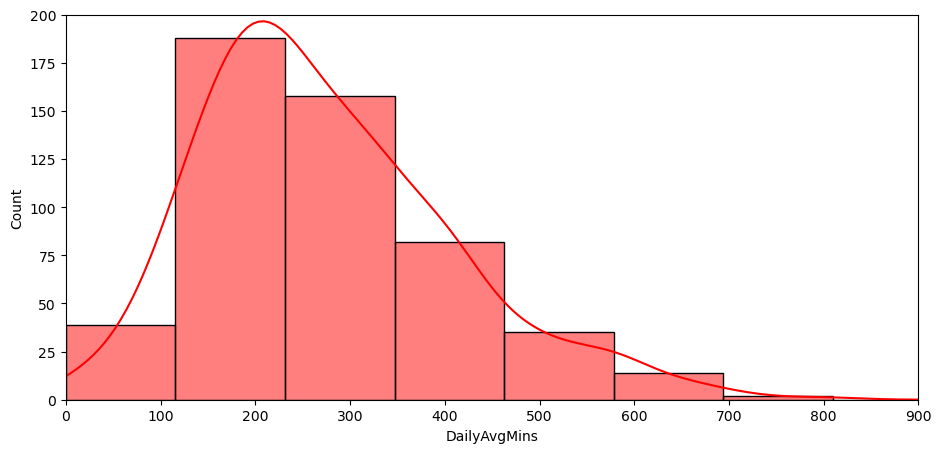

In [25]:
# With a histrogram we can easily visualize the distribution of DailyAvgMin.

fig, ax = plt.subplots()
sns.histplot(df['DailyAvgMins'],bins=10, kde=True, color="red")  # distplot is deprecate and replaced by histplot
ax.set_xlim(0,900)
ax.set_ylim(0,200)
fig.set_size_inches(11,5)

plt.show()

#We can conclude that this variable seems to be normally dsitributed.

Text(0.5, 1.0, 'Boxplot of Daily Average Minutes')

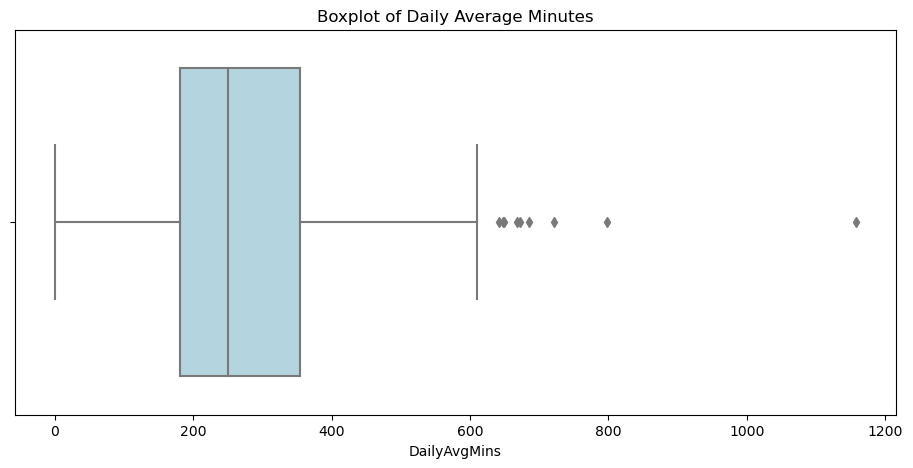

In [26]:
#With a box plot we can easily get a notion of the mean, variance and outliers. 

plt.figure(figsize=(25,5))
plt.subplot(1, 2, 1)
sns.boxplot(x=df['DailyAvgMins'], color='lightblue')
plt.title('Boxplot of Daily Average Minutes')
#We can conclude that while there does seem to be one outlier quite far from the mean, it is just one value and so does not concern us for a dataset with over 500 samples.
#We can also conclude that the mean is aproximately 250 and the range goes from about 0 to about 650.

**c. Provide at least 2 appropriate plots (for each) to check the relationship between the:**

**i. Participant’s age and their Response time on singleton visual search   
ii. Participant’s gender and their Response time on conjunction visual search**

<Figure size 50000x500 with 0 Axes>

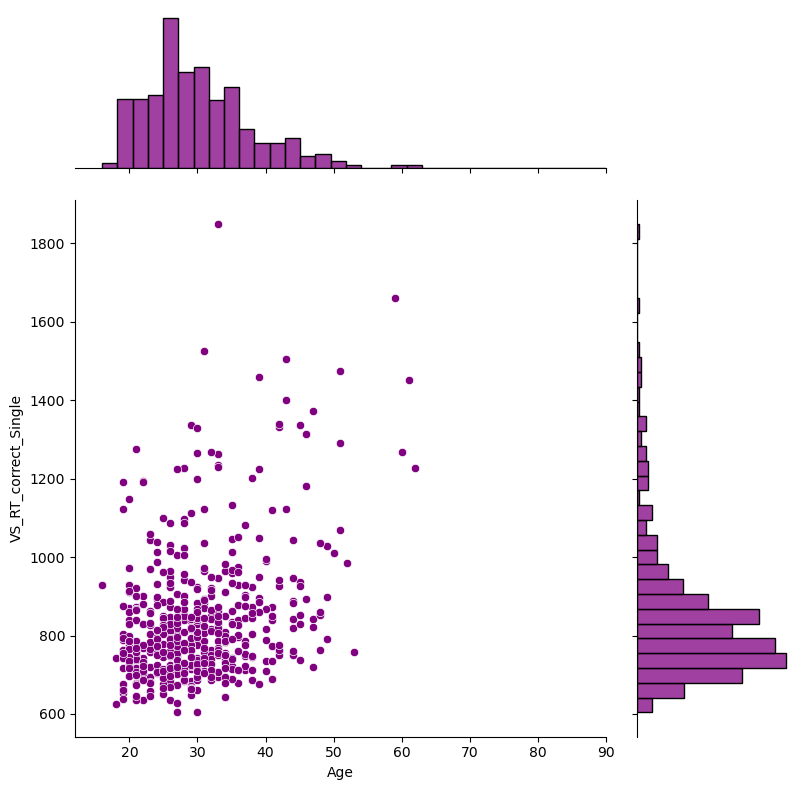

In [27]:
# i. Participant’s age and their Response time on singleton visual search 

#With a jointplot we can see both a scatterplot that helps us understand the relationship between participants' age and their RT on singleton visual search as well as
#A histogram for each variable that allow us to see their distribution.

plt.figure(figsize=(500,5))
sns.jointplot(x='Age', y='VS_RT_correct_Single', data=df, xlim=(12,90), color='purple',height=8, ratio=3)

plt.show()

#From this we can conclude that they both seem to have a normal distribution and that they don't seem to have a high correlation value (although we can perceive it is
#a positive correlaiton (if one value increases so does the other one).

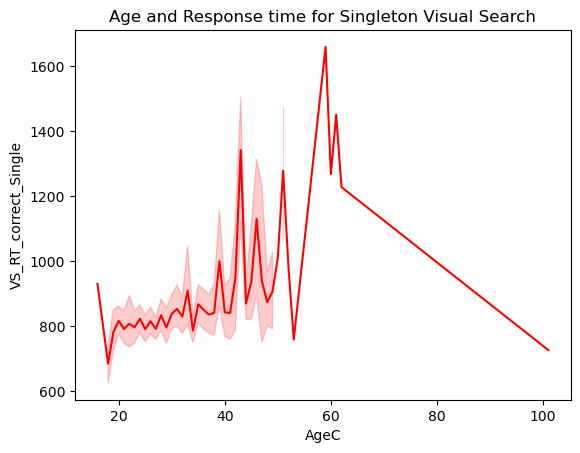

In [28]:
# With a pair plot we can gr[ahically line the relationship between two continuous, numeric variables
# Create pair plot with custom settings

dataTemp = {'AgeC': df['Age'],
        'VS_RT_correct_Single':df['VS_RT_correct_Single']}
dfTemp = pd.DataFrame(dataTemp)

sns.lineplot(x="AgeC", y="VS_RT_correct_Single", data=dfTemp, color="red")

# Set title

plt.title("Age and Response time for Singleton Visual Search")

# Show plot

plt.show()

#From this we can also conclude that they seem to have a positive correlation. Given that they are both normally distributed, we can also infer that the variance is quite high.

In [29]:
# ii. Participant’s gender and their Response time on conjunction visual search
#Because gender is categorical, it would be interesting to compare across categories


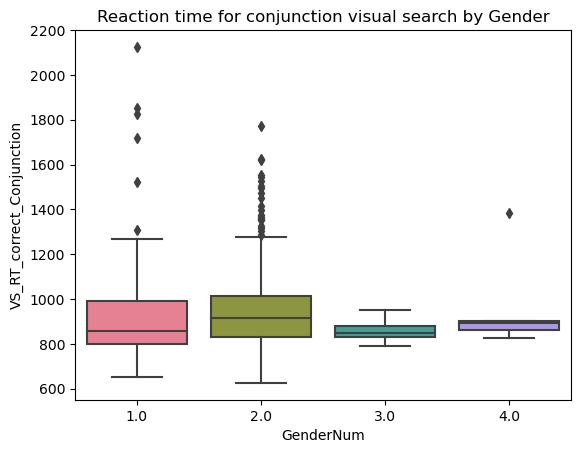

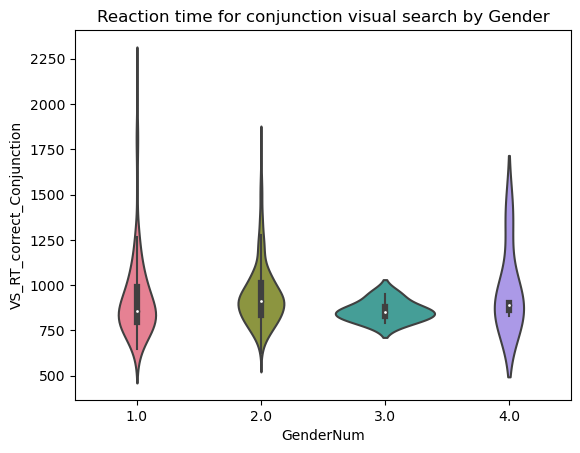

In [30]:
#Like we did previously, with box and violin plots we can easily compare means and variance for the the RT amongst different genders.

sns.boxplot(x='GenderNum', y='VS_RT_correct_Conjunction', data=df, palette='husl')
plt.title('Reaction time for conjunction visual search by Gender')
plt.show()

sns.violinplot(x='GenderNum', y='VS_RT_correct_Conjunction', data=df, palette='husl')
plt.title('Reaction time for conjunction visual search by Gender')
plt.show()

#From this we can conclude that genders 1 and 2 have many more outliers than the remaining two genders. They also seem to have a much grater variance.
#For genders 1 and 3 we also realize that their mean is closer to their minimum, while gender 4's is closer to its maximum and gender 2's is close to its median.


Text(0, 0.5, 'Density')

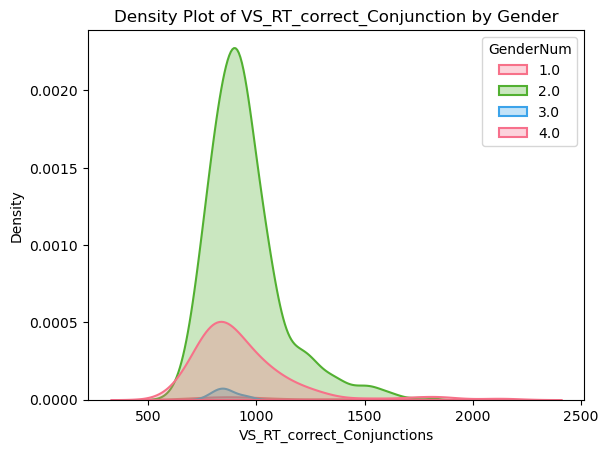

In [31]:
# With a density plot we can observe the distribution RT by Gender in a way that is easy to compare. Density plots are a variation of Histograms.
# We create the plot and adjust the "alpha" and "linewidth" parameters to make the plot more visually appealing and add the neccesary labels.

sns.kdeplot(data=df, x="VS_RT_correct_Conjunction", hue="GenderNum", fill=True, palette="husl",alpha=0.3, linewidth=1.5)
plt.title("Density Plot of VS_RT_correct_Conjunction by Gender")
plt.xlabel("VS_RT_correct_Conjunctions")
plt.ylabel("Density")

#We can conclude what we already saw in the previous graphs, genders 3 and 4 seem to have a lesser variance.

# 3. Correlation Check: Produce a bivariate correlation table between Age, STAI, BRIEF_Total, DailyAvgMins and VS_RT_correct_Single.**

**Sources used for this section:**

QuantHub. (n.d.). How to Read a Correlation Matrix. Retrieved from https://www.quanthub.com/how-to-read-a-correlation-matrix/#:~:text=Positive%20numbers%20indicate%20positive%20correlations,correlation%20between%20the%20two%20variables.

Statology. (n.d.). How to Read a Correlation Matrix. Retrieved from https://www.statology.org/how-to-read-a-correlation-matrix/

                           AgeC     STAIC  BRIEF_TotalC  DailyAvgMinsC  \
AgeC                   1.000000 -0.117021     -0.079665      -0.100580   
STAIC                 -0.117021  1.000000      0.647794       0.026361   
BRIEF_TotalC          -0.079665  0.647794      1.000000       0.081463   
DailyAvgMinsC         -0.100580  0.026361      0.081463       1.000000   
VS_RT_correct_SingleC  0.321803 -0.078624      0.016845      -0.003614   

                       VS_RT_correct_SingleC  
AgeC                                0.321803  
STAIC                              -0.078624  
BRIEF_TotalC                        0.016845  
DailyAvgMinsC                      -0.003614  
VS_RT_correct_SingleC               1.000000  


<function matplotlib.pyplot.show(close=None, block=None)>

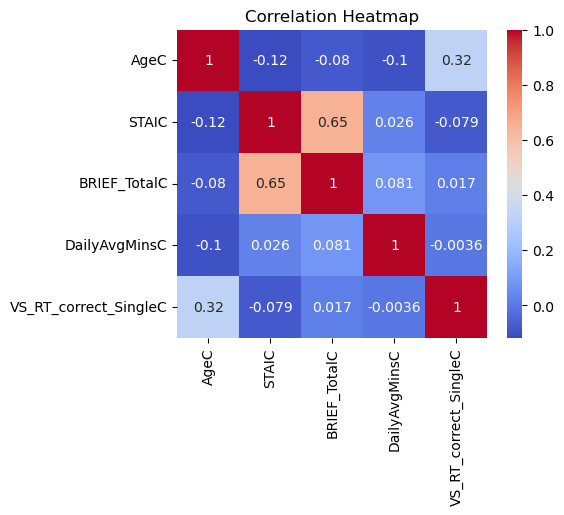

In [32]:
# Create correlation matrix
dataC = {'AgeC':df['Age'],
        'STAIC':df['STAI'],
        'BRIEF_TotalC':df['BRIEF_Total'],
        'DailyAvgMinsC':df['DailyAvgMins'],
        'VS_RT_correct_SingleC':df['VS_RT_correct_Single']}

dfC = pd.DataFrame(dataC)

# Calculate the correlation matrix
correlation_matrix = dfC.corr()

# Print the matrix and create a heat map
print(correlation_matrix)
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns, cmap='coolwarm', annot=True)
plt.title("Correlation Heatmap")
plt.show


**Conclusion:**
We can conclude strength and direction of correlations from this matrix:

1) We can conclude that all variables except VS_RT_correct_Single have a weak negative correlation with Age. This means that higher values in those other variables is weakly associated with lower Age values (and viceversa). 
2) STAIC and BRIEF_Total have a strong positive correlation, this means that higher values in STAIC are associated with higher values in BRIEF_Total (and viceversa).
3) VS_RT_correct_Single has a  weak negative correlation with STAIC and DailyAvgMins which means that higher values in VS_RT_correct_Single is weakly associated with lower values in both STAIC and DailyAvgMins.
4) All other correlations not explicitly mentioned here are weak positive correlations which means that a higher value in one variable is weakly associated with an increase in the other.


# 4. Linear Regression: Perform a linear regression to see if DailyAvgMins predicts VS_RT_correct_Single

In [33]:
data = {'DailyAvgMins': df['DailyAvgMins'],
        'VS_RT_correct_Single': df['VS_RT_correct_Single']}

df_regression = pd.DataFrame(data)

# Define the dependent and independent variables
X = sm.add_constant(df_regression['DailyAvgMins'])  # Add a constant term to the predictor
y = df_regression['VS_RT_correct_Single']

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     VS_RT_correct_Single   R-squared:                       0.000
Model:                              OLS   Adj. R-squared:                 -0.002
Method:                   Least Squares   F-statistic:                  0.006752
Date:                  Mon, 04 Dec 2023   Prob (F-statistic):              0.935
Time:                          15:11:14   Log-Likelihood:                -3391.7
No. Observations:                   519   AIC:                             6787.
Df Residuals:                       517   BIC:                             6796.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          843.1902     

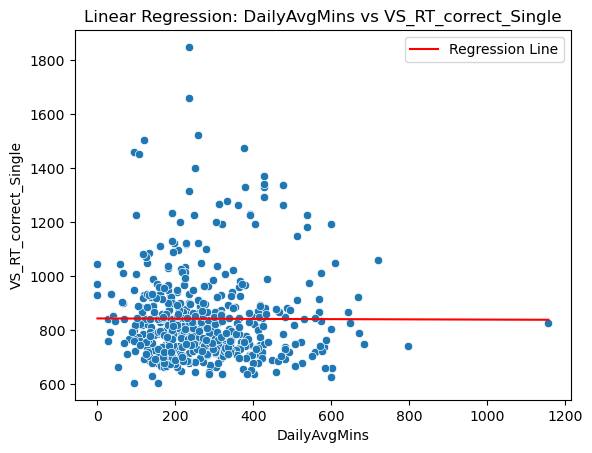

In [34]:
# Plot the regression line
sns.scatterplot(x='DailyAvgMins', y='VS_RT_correct_Single', data=df_regression)
sns.lineplot(x=X['DailyAvgMins'], y=model.predict(X), color='red', label='Regression Line')
plt.title('Linear Regression: DailyAvgMins vs VS_RT_correct_Single')
plt.xlabel('DailyAvgMins')
plt.ylabel('VS_RT_correct_Single')
plt.legend()
plt.show()


Conclusion: R2 is very low and our scatter plot seems to just be random points without following the tendency of the pltted line. From this we can infer that there doesn't seem to be a linear relationship that we can use to predict VS_RT_correct_Single using the daily average minutes of usage.

# 5. Multiple Regression: Add predictors Age, GenderNum, STAI, BRIEF_Total and DailyAvgPickups to the multiple regression model. Does the amount of variance accounted for in the outcome increase? Is DailyAvgMins a significant predictor of the outcome?

In [35]:
# Separate the data
X = df[['Age', 'GenderNum', 'STAI', 'BRIEF_Total', 'DailyAvePickups', 'DailyAvgMins']]
y = df['VS_RT_correct_Single']  

# Add constant term
X = sm.add_constant(X)

# Fit and show the multiple regression model
model = sm.OLS(y, X).fit()
print(model.summary())



                             OLS Regression Results                             
Dep. Variable:     VS_RT_correct_Single   R-squared:                       0.185
Model:                              OLS   Adj. R-squared:                  0.176
Method:                   Least Squares   F-statistic:                     19.41
Date:                  Mon, 04 Dec 2023   Prob (F-statistic):           1.92e-20
Time:                          15:11:15   Log-Likelihood:                -3338.5
No. Observations:                   519   AIC:                             6691.
Df Residuals:                       512   BIC:                             6721.
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             836.

**Residuals Plot:**
Plot the residuals (the differences between the observed and predicted values) to check for homoscedasticity (constant variance of residuals) and identify potential patterns.


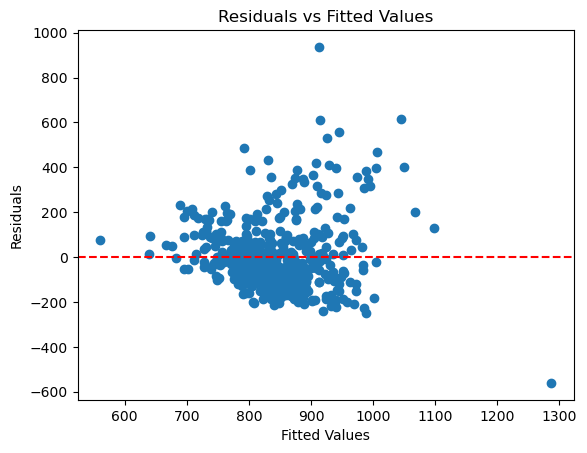

In [36]:
# Residuals vs Fitted Values Plot
residuals = model.resid
fitted_values = model.fittedvalues

plt.scatter(fitted_values, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

**Partial Regression Plots:**
Create partial regression plots to visualize the relationship between individual predictors and the response variable while holding other predictors constant.

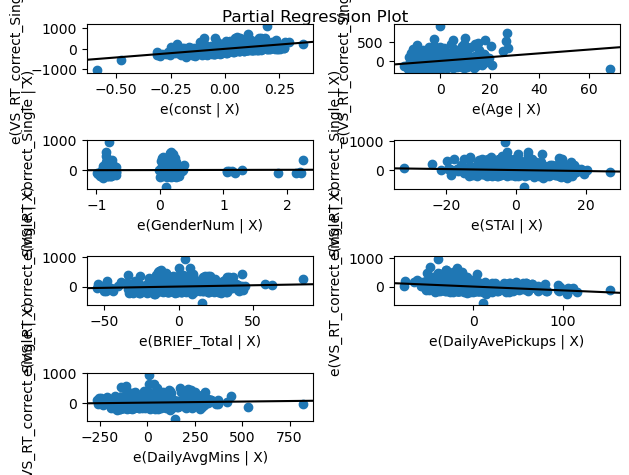

<Figure size 40000x40000 with 0 Axes>

In [37]:
# Partial Regression Plots
sm.graphics.plot_partregress_grid(model)
plt.figure(figsize=(400, 400))
plt.show()


**Check for Multicollinearity:**
Plot the variance inflation factor (VIF) for each predictor to check for multicollinearity.

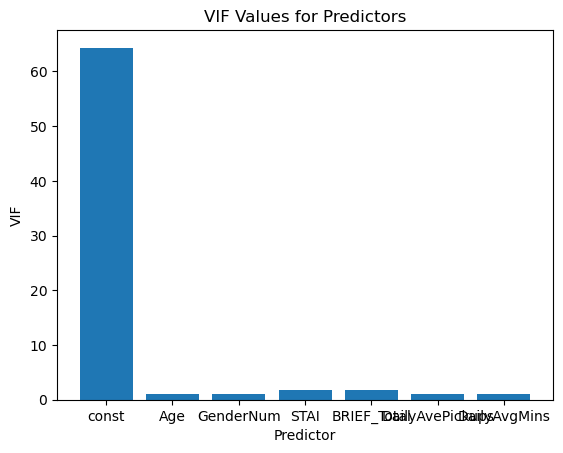

In [38]:
# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Plot VIF values
plt.bar(vif_data["Variable"], vif_data["VIF"])
plt.title('VIF Values for Predictors')
plt.xlabel('Predictor')
plt.ylabel('VIF')
plt.show()

**Conclusion:**

Our p value is greater that 0.05 which means we can't reject the null hypothesis and daily average ,inutes of usage is likely not a good predictor for VS_RT_correct_Single. STAI, BRIEF and daily pickups would all be better predictor.

In terms of multicollinearity, all VIFs semm to be less than 5 which generally indicates low multicollinearity.

# 6. Scenario 1:

**a. Participants including male, female and non-binary from various age groups
took part in a study which ran for a week.**

**b. They were grouped under three Age Groups a< =30 years, b: 31 to 49 years,
and c >= 50 years**

**c. And then their mobile usage was monitored, and the daily average minutes of
usage was recorded.**

**d. And the usage (average minutes per day) was grouped under three Usage
Groups a =< 300 minutes, b= b: 301 to 899 minutes, or c >= 900 minutes**

**e. Then they were asked to locate target red apple amongst distractors of only
blue apples (known as Singleton search) and Mean time to identify was
recorded (reaction time; RT)**

***Perform the following points based on Scenario 1:**


**Sources used for this section:**

AM Statistical Consulting. (n.d.). Two-Way ANOVA. Retrieved from https://www.amstatisticalconsulting.com/two-way-anova/

SciPy. (n.d.). scipy.stats.bartlett. Retrieved from https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bartlett.html

Kaggle. (n.d.). Python Homogeneity of Variance Check. Retrieved from https://www.kaggle.com/code/nenamalikah/python-homogeneity-of-variance-check

Statology. (n.d.). ANOVA Assumptions. Retrieved from https://www.statology.org/anova-assumptions/

Analytics Vidhya. (2020). Introduction to ANOVA Statistics in Data Science. Retrieved from https://www.analyticsvidhya.com/blog/2020/06/introduction-anova-statistics-data-science-covid-python/

Statology. (n.d.). Two-Way ANOVA in Python. Retrieved from https://www.statology.org/two-way-anova-python/

GeeksforGeeks. (n.d.). How to Perform a Two-Way ANOVA in Python. Retrieved from https://www.geeksforgeeks.org/how-to-perform-a-two-way-anova-in-python/

https://www.pythonfordatascience.org/anova-python/

https://www.reneshbedre.com/blog/mixed-anova.html

**f. Create any groups described above and choose appropriate Omnibus test
statistic for Scenario 1 to test the following hypothesis:**

The researcher hypothesised that as participant mobile phone use increased, the time taken for them to find the search target would decrease in singleton search, with the greatest decrease in participants less than 30 years-of-age.


In [39]:
#i. Create neccesary age and mobile usage groups

In [40]:
# Define the bins and labels for age groups
bins = [0, 30, 49, float('inf')]  # Adjusted bin edges
labels = ['A', 'B', 'C']

# Create a new column 'DailyAvgMins_Group' with the assigned groups
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Display the DataFrame with the new column
print(df)

     Year   Age  GenderNum AutismQuotient  STAI  BRIEF_Total  Device  \
1    2021  37.0        2.0              8  44.0         33.0       1   
5    2020  24.0        2.0              6  47.0          0.0       1   
6    2022  28.0        2.0              6  49.0         70.0       1   
7    2021  31.0        2.0              1  43.0         44.0       3   
8    2021  33.0        2.0              2  51.0         24.0       3   
..    ...   ...        ...            ...   ...          ...     ...   
543  2020  38.0        1.0              3  56.0         39.0       3   
544  2020  27.0        2.0              5  64.0         77.0       3   
545  2020  36.0        2.0              2  46.0         43.0       3   
546  2020  31.0        2.0              4  67.0         69.0       3   
547  2020  35.0        2.0              1  42.0         24.0       3   

     DailyAvgMins  DailyAvePickups  VS_RT_correct_Conjunction  \
1           180.5            101.5                 946.470000   
5    

In [41]:
# Define the bins and labels for mobile usage groups
bins = [0, 300, 899, float('inf')]  # Adjusted bin edges
labels = ['A', 'B', 'C']

# Create a new column 'DailyAvgMins_Group' with the assigned groups
df['DailyAvgMins_Group'] = pd.cut(df['DailyAvgMins'], bins=bins, labels=labels, right=False)

# Display the DataFrame with the new column
print(df)

     Year   Age  GenderNum AutismQuotient  STAI  BRIEF_Total  Device  \
1    2021  37.0        2.0              8  44.0         33.0       1   
5    2020  24.0        2.0              6  47.0          0.0       1   
6    2022  28.0        2.0              6  49.0         70.0       1   
7    2021  31.0        2.0              1  43.0         44.0       3   
8    2021  33.0        2.0              2  51.0         24.0       3   
..    ...   ...        ...            ...   ...          ...     ...   
543  2020  38.0        1.0              3  56.0         39.0       3   
544  2020  27.0        2.0              5  64.0         77.0       3   
545  2020  36.0        2.0              2  46.0         43.0       3   
546  2020  31.0        2.0              4  67.0         69.0       3   
547  2020  35.0        2.0              1  42.0         24.0       3   

     DailyAvgMins  DailyAvePickups  VS_RT_correct_Conjunction  \
1           180.5            101.5                 946.470000   
5    

**ii. Justify reasons for choosing the test**

We have chosen to conduct a 2-way ANOVA to test how Age, DailyAvgMins and their interaction effect singleton RT.

The reason for choosing a 2-way ANOVA instead of a 2x2 mixed ANOVA lies in the type of IVs we are handling. In this case, the assumption of independence is fully met for both Age_Groups and DailyAvgMins_Group. This means that the individuals in one group have no influence over those in another, one person's age will not effect some one elses ages for example. It also means that one participant cannot be in more than one Age group or more than one DailyAvgMins group. 

Since our IVs are both ordinal (categorical with an order) and our DV is continuous and numerical, we are able to apply the 2-way Anova without any setbacks.


**iii. List the details of assumptions and the corresponding statistic test deployed to achieve it (in a markdown cell) (Example assumptions (but not limited to) may be Normality, Variance, Linearity etc.,)**

Normality: The values of the dependent variable should follow a bell curve (they should be normally distributed). To test normality we will create a QQplot for our model and compare how our data relates to the plot line.

Homogeneity of variance (a.k.a. homoscedasticity): The variation around the mean for each group being compared should be similar among all groups. If the assumption of normality is met, we can conduct a Barlett test. If not, we must conduct Levenes test.

Independence of observations: Independent variables should not be dependent on one another (i.e. one should not cause or influence the other and a person should not belong to two or more groups within the same variable) and were collected randomly.

We will assume that the experiment has been designed properly and therefore variables were collected randomly and don't neccesarily depend on eachother. We will also assume there are no significant outliers.



**iv. Check validity of those assumptions and provide appropriate visual
charts.** Note: If there are deviations, apply methods of rectification before the
test is applied on the dataset


In [42]:
#Create the 2-way Anova model
model = ols('VS_RT_correct_Single ~ Age_Group * DailyAvgMins_Group', data=df).fit()
result=sm.stats.anova_lm(model, type=2)
print (result)

                                 df        sum_sq        mean_sq          F  \
Age_Group                       2.0  1.640207e+06  820103.267602  32.966643   
DailyAvgMins_Group              2.0  3.331183e+03    1665.591366   0.066954   
Age_Group:DailyAvgMins_Group    4.0  2.325247e+05   58131.169702   2.336766   
Residual                      512.0  1.273690e+07   24876.760292        NaN   

                                    PR(>F)  
Age_Group                     3.407350e-14  
DailyAvgMins_Group            9.352467e-01  
Age_Group:DailyAvgMins_Group  5.445115e-02  
Residual                               NaN  


In [43]:
# Since all p-values are less than .05, we can conclude that Age, DailyAvgMins and there interaction don't have a significant effect on the reaction time for the singleton test.

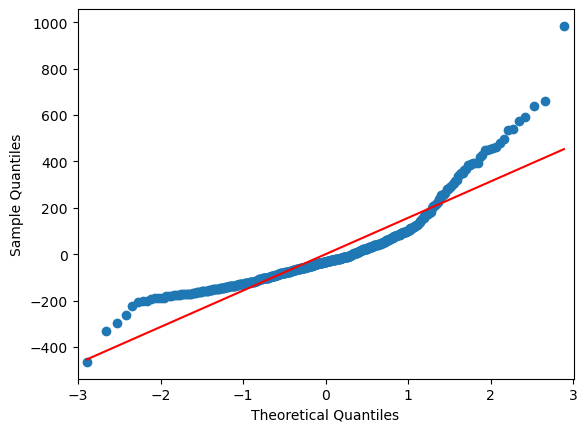

In [44]:
# To test for Normality, we use the model's residuals to plot a QQplot

#Obtain residuals
res = model.resid
#Plot QQ Plot
fig = sm.qqplot(res, line='s')
plt.show()


**Conclusion:** From this QQ plot we can assume that the data follows a normal distribution as it is relatively close to the
plot line. We can also conclude that because we have more than 500 samples, our data follows the central data theorem and therefore tends towards the center.

In [45]:
# Checking for equal variances - starting out with age groups
# Separate each group
AgegroupA = df[df['Age_Group'] == 'A']['Age']
AgegroupB = df[df['Age_Group'] == 'B']['Age']
AgegroupC = df[df['Age_Group'] == 'C']['Age']

# Perform Bartlett's test
statistic, p_value = bartlett(AgegroupA, AgegroupB, AgegroupC)

# Print the results
print("Bartlett Test Statistic:", statistic)
print("P-value:", p_value)

# Interpret the results
if p_value > 0.05:
    print("Can't reject the null hypothesis. Variances are equal.")
else:
    print("Reject the null hypothesis. Variances are not equal.")


Bartlett Test Statistic: 128.98776624932054
P-value: 9.787289677205494e-29
Reject the null hypothesis. Variances are not equal.


**Comments and conclusions:** From this Bartlett test we can conclude that the variances are not equal. We would need to coundct a non parametric test such as Kruskal-Wallis or a Welsh Anova but will not ge to that point because it is not part of the current assignment.

**v. Use appropriate follow-on tests to identify where the specific effects lie (e.g. between which IV levels or combination of levels).**

Had there been a significant effect, we would follow up with a post hoc tests to identify specific differences between groups. Two potential tests for this would be 

Tukey's Honestly Significant Difference to determine difference between group means (to see if a certain group has amore signifoicant effect) or a Bonferroni Correction to adjust the significance level based on the number of comparisons.


# 7. Scenario 2:

**For Scenario 2 we are going to transform the existing data to fake a different set of empirical data. Sort the existing dataset by VS_RT_correct_Single
(Descending order) and rename “VS_RT_correct_Conjunction” ----> “VS_RT_Before” and “VS_RT_correct_Single” ----> “VS_RT_After”**

**a. Participants including male, female and non-binary (i.e. Gender) took part in a study which ran a week span.**

**b. Then they were asked to locate target red apple amongst distractors of both blue apples and red slices and Mean time to identify was recorded (reaction time; VS_RT_Before).**

**c. Create a new variable “Brain Training” and randomly allocate half the participants to a Trained and the other half to a non-trained group.**

**d. Their mobile usage was monitored, and the daily average minutes of usage was recorded. And the usage (average minutes per day) was grouped under three UsageGroup categories a =< 300 minutes, b= b: 301 to 899 minutes, or c >= 900 minutes**

**e. They were finally asked to locate target red apple amongst distractors of only blue apples (Singleton Search) and Mean time to identify was recorded (reaction time; VS_RT_AOer).** 

**Perform the points detailed below, based on the Scenario 2.**

**i. Create any groups described above and choose appropriate Omnibus test statistic for Scenario 2 to test the hypothesis stated below:** 

Hypothesis: The researcher hypothesised that as participant mobile phone use increased, the time taken for them to find the search target would decrease, with the greatest decrease in female participants after playing brain games.

In [46]:
#In order to avoid confusion we will not rename the existing VS_RT_correct_Conjunction column but create a new one with the same values

df['VS_RT_Before']= df['VS_RT_correct_Conjunction']

In [47]:
#In order to avoid confusion we will not rename the existing VS_RT_correct_Single column but create a new one with the same values

df['VS_RT_After']= df['VS_RT_correct_Single']
print(df)

     Year   Age  GenderNum AutismQuotient  STAI  BRIEF_Total  Device  \
1    2021  37.0        2.0              8  44.0         33.0       1   
5    2020  24.0        2.0              6  47.0          0.0       1   
6    2022  28.0        2.0              6  49.0         70.0       1   
7    2021  31.0        2.0              1  43.0         44.0       3   
8    2021  33.0        2.0              2  51.0         24.0       3   
..    ...   ...        ...            ...   ...          ...     ...   
543  2020  38.0        1.0              3  56.0         39.0       3   
544  2020  27.0        2.0              5  64.0         77.0       3   
545  2020  36.0        2.0              2  46.0         43.0       3   
546  2020  31.0        2.0              4  67.0         69.0       3   
547  2020  35.0        2.0              1  42.0         24.0       3   

     DailyAvgMins  DailyAvePickups  VS_RT_correct_Conjunction  \
1           180.5            101.5                 946.470000   
5    

In [48]:
# We already have a variable that groups DailyAvgMin, we will keep that same column as there is no need to create a new one

In [49]:
#Create a new variable for brain training and assign half of the participants to being trained and the other half to untrained
# Create a new column 'BrainTraining' and set it as 'Non-Trained', we will also create a column for participant IDs
df['BrainTraining'] = 0
df['ParticipantID'] = range(1, len(df) + 1)
participant_ids = df['ParticipantID']

# Randomly select half of the participants
num_participants_trained = len(participant_ids) // 2
participants_trained = np.random.choice(participant_ids, size=num_participants_trained, replace=False)

# Assign 'Trained' to the selected participants
df.loc[df['ParticipantID'].isin(participants_trained), 'BrainTraining'] = '1'

# Display the updated DataFrame
print(df)

     Year   Age  GenderNum AutismQuotient  STAI  BRIEF_Total  Device  \
1    2021  37.0        2.0              8  44.0         33.0       1   
5    2020  24.0        2.0              6  47.0          0.0       1   
6    2022  28.0        2.0              6  49.0         70.0       1   
7    2021  31.0        2.0              1  43.0         44.0       3   
8    2021  33.0        2.0              2  51.0         24.0       3   
..    ...   ...        ...            ...   ...          ...     ...   
543  2020  38.0        1.0              3  56.0         39.0       3   
544  2020  27.0        2.0              5  64.0         77.0       3   
545  2020  36.0        2.0              2  46.0         43.0       3   
546  2020  31.0        2.0              4  67.0         69.0       3   
547  2020  35.0        2.0              1  42.0         24.0       3   

     DailyAvgMins  DailyAvePickups  VS_RT_correct_Conjunction  \
1           180.5            101.5                 946.470000   
5    

**ii. Justify reasons for choosing the test.**

In order to test the hypothesis we want to compare within subjects (before and after), we also want to be able to compare between different types of subjects (females vs. the other two genders).

A mixed Anova will allow us to analyze the effects of both within-subjects factors (e.g., before and after) and between-subjects factors (e.g., Brain Games and Gender). 

In order to accomplish this will need to create a variable that captures the difference in reaction time (after - before).

These are the assumption we will be taking into account for this test:

1) Normality: The values of the dependent variable should follow a bell curve (they should be normally distributed). To test normality we will create a QQplot for our model and compare how our data relates to the plot line.

2) Homogeneity of variance (a.k.a. homoscedasticity): The variation around the mean for each group being compared should be similar among all groups. If the assumption of normality is met, we can conduct a Barlett test. If not, we must conduct Levenes test.

3) Independence of observations: Independent variables should not be dependent on one another (i.e. one should not cause or influence the other and a person should not belong to two or more groups within the same variable) and were collected randomly.

We will assume that the experiment has been designed properly and therefore variables were collected randomly and don't neccesarily depend on eachother. We will also assume there are no significant outliers.

Since our IVs are both categorical and our DV is continuous and numerical, we are able to apply the mixed Anova without any setbacks.


In [50]:
# To conduct the Anova we need to create a new column in the data set that contains a variable for the change in reaction time. 
# To calculate this we subtract 'VS_RT_After' from 'VS_RT_Before'

for i in range(len(df['ParticipantID'])):
    df['ChangeinRT']= df['VS_RT_After']-df['VS_RT_Before']
print (df)

     Year   Age  GenderNum AutismQuotient  STAI  BRIEF_Total  Device  \
1    2021  37.0        2.0              8  44.0         33.0       1   
5    2020  24.0        2.0              6  47.0          0.0       1   
6    2022  28.0        2.0              6  49.0         70.0       1   
7    2021  31.0        2.0              1  43.0         44.0       3   
8    2021  33.0        2.0              2  51.0         24.0       3   
..    ...   ...        ...            ...   ...          ...     ...   
543  2020  38.0        1.0              3  56.0         39.0       3   
544  2020  27.0        2.0              5  64.0         77.0       3   
545  2020  36.0        2.0              2  46.0         43.0       3   
546  2020  31.0        2.0              4  67.0         69.0       3   
547  2020  35.0        2.0              1  42.0         24.0       3   

     DailyAvgMins  DailyAvePickups  VS_RT_correct_Conjunction  \
1           180.5            101.5                 946.470000   
5    

In [51]:
print(df.dtypes)

df['BrainTraining'] = df['BrainTraining'].astype(int)
df['GenderNum'] = df['GenderNum'].astype(int)
df['ChangeinRT'] = df['ChangeinRT'].astype(int)

print(df.dtypes)

Year                            int64
Age                           float64
GenderNum                     float64
AutismQuotient                 object
STAI                          float64
BRIEF_Total                   float64
Device                          int64
DailyAvgMins                  float64
DailyAvePickups               float64
VS_RT_correct_Conjunction     float64
VS_RT_correct_Single          float64
Age_Group                    category
DailyAvgMins_Group           category
VS_RT_Before                  float64
VS_RT_After                   float64
BrainTraining                  object
ParticipantID                   int64
ChangeinRT                    float64
dtype: object
Year                            int64
Age                           float64
GenderNum                       int64
AutismQuotient                 object
STAI                          float64
BRIEF_Total                   float64
Device                          int64
DailyAvgMins                  float6

In [52]:
# Assuming 'GenderNum' is a between-subject factor and 'BrainTraining' is a within-subject factor
formula = 'ChangeinRT ~ C(GenderNum) + C(BrainTraining) + C(GenderNum):C(BrainTraining)'
model = ols(formula, data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)

                                     sum_sq     df         F    PR(>F)
C(GenderNum)                   1.162660e+03    3.0  0.062424  0.979594
C(BrainTraining)               3.633049e+01    1.0  0.005852  0.939053
C(GenderNum):C(BrainTraining)  1.374925e+04    3.0  0.738206  0.529590
Residual                       3.172495e+06  511.0       NaN       NaN


**Conclusion:**

We will include the final conclusions of the test after testing for the parametric assumptions in the following points.



**iii. And WRT to the test you have finalized list the details of assumptions and the corresponding statistic test deployed to achieve it (in a markdown cell) (Example assumptions (but not limited to) may be Normality, Variance, Linearity etc.,)**

We have already included a detailed list of the assumptions on subpoint ii) and will conduct them in the following subpoint.

**iv. Check validity of those assumptions and provide appropriate visual charts.**
Note: If there are deviations, apply methods of rectification before the test is applied on the dataset

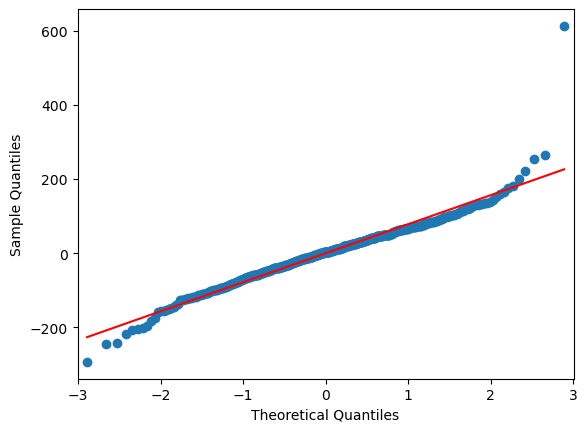

In [53]:
# To test for Normality, we use the model's residuals to plot a QQplot

#Obtain residuals
res = model.resid
#Plot QQ Plot
fig = sm.qqplot(res, line='s')
plt.show()


**Conclusion:** From this QQ plot we can assume that the data follows a normal distribution as it is relatively close to the
plot line. We can also conclude that because we have more than 500 samples, our data follows the central data theorem and therefore tends towards the center.

In [54]:
# Checking for equal variances - starting out with age groups
# Separate each group
Gendergroup1 = df[df['GenderNum'] == '1']
Gendergroup2 = df[df['GenderNum'] == '2']
Gendergroup3 = df[df['GenderNum'] == '3']
Gendergroup4 = df[df['GenderNum'] == '4']

# Perform Bartlett's test
statistic, p_value = bartlett(Gendergroup1, Gendergroup2, Gendergroup3, Gendergroup4)

# Print the results
print("Bartlett Test Statistic:", statistic)
print("P-value:", p_value)

# Interpret the results
if p_value > 0.05:
    print("Can't reject the null hypothesis. Variances are equal.")
else:
    print("Reject the null hypothesis. Variances are not equal.")


Bartlett Test Statistic: nan
P-value: nan
Reject the null hypothesis. Variances are not equal.


**Comments and conclusions:** From this Bartlett test we can conclude that the variances are not equal. We would need to coundct a non parametric test such as Kruskal-Wallis or a Welsh Anova but will not ge to that point because it is not part of the current assignment.

**Final conclusions on the Anova:**
    
Since we don't need to conduct non-parametric tests or transform for normality and equal variance in this assignment, we will assume that the parametric assumptions were met and can therefore make conclusions based on our mixed anova test.

There are no p-values that are significant (<0.05) in our anova, so we cannot conclude that there is a difference in reaction time for different genders once they complete that brain training. 

Had there been a significant variable, we would conduct post hoc tests to identify differences between groups oin a more specific way.

**iv. Use appropriate follow-on tests to identify where the specific effects lie (e.g. between which IV levels or combination of levels)**

Post hoc comparisons (no specific prediction):
- Alpha level .05 must be corrected for the total number of possible corrections even if all not performed(e.g. Bonferroni)
- More likely to make a Type II error (i.e., false negative)
- If you have done planned tests, then all the hypotheses of interest have been examined. If you do not have any hypotheses, then you shouldn’t be doing any planned tests, they should all be post hoc.
- If test is conservative, then probability of Type I (i.e., reject the null hypothesis when it is true) is small but Type II (i.e., fail to reject the null hypothesis when it’s false) is large.
- If test is lenient, then probability of Type I is large and Type II is small.

# 8. Final adjusted MASTER Data set

In [56]:
# Assuming df is your DataFrame
df.to_csv('df_finalAdjusted', index=False)